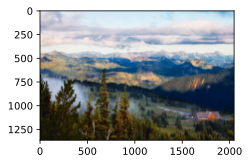

In [1]:
%matplotlib inline
import numpy as np
import mindspore
import mindspore.ops as ops
import mindspore.nn as nn
import mindspore.dataset.vision as vision
import mindspore.dataset.transforms as transforms
from mindspore import Parameter
from mindspore.common.initializer import initializer
from d2l import mindspore as d2l

d2l.set_figsize()
content_img = d2l.Image.open('../img/rainier.jpg')
d2l.plt.imshow(content_img);

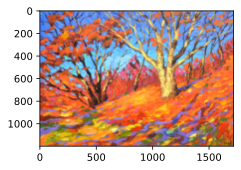

In [2]:
style_img = d2l.Image.open('../img/autumn-oak.jpg')
d2l.plt.imshow(style_img);

In [3]:
rgb_mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
rgb_std = [0.229 * 255, 0.224 * 255, 0.225 * 255]

def preprocess(img, image_shape):
    transform = transforms.Compose([
        vision.Resize(image_shape),
        vision.Normalize(mean=rgb_mean, std=rgb_std),
        vision.HWC2CHW(),
        vision.ToNumpy()
    ])
    return mindspore.Tensor(transform(img))

def postprocess(img):
    img = img[0]
    #print(img)
    img = ops.maximum(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0)
    img = ops.minimum(img, 255)
    img = img.asnumpy().astype('uint8')
    return vision.ToPIL()(img)

In [4]:
import mindcv

pretrained_net = mindcv.create_model('vgg19', pretrained=False)
param = mindspore.load_checkpoint('./1.ckpt')
net = mindspore.load_param_into_net(pretrained_net, param)

[WARNING] ME(176498:281473357277760,MainProcess):2023-03-05-11:44:28.109.735 [mindspore/common/api.py:840] 'mindspore.ms_class' will be deprecated and removed in a future version. Please use 'mindspore.jit_class' instead.
[WARNING] ME(176498:281473357277760,MainProcess):2023-03-05-11:44:28.143.843 [mindspore/common/api.py:694] 'mindspore.ms_function' will be deprecated and removed in a future version. Please use 'mindspore.jit' instead.
[WARNING] ME(176498:281473357277760,MainProcess):2023-03-05-11:44:28.146.711 [mindspore/common/api.py:694] 'mindspore.ms_function' will be deprecated and removed in a future version. Please use 'mindspore.jit' instead.
[WARNING] ME(176498:281473357277760,MainProcess):2023-03-05-11:44:32.774.459 [mindspore/train/serialization.py:1024] For 'load_param_into_net', 1 parameters in the 'net' are not loaded, because they are not in the 'parameter_dict', please check whether the network structure is consistent when training and loading checkpoint.
[WARNING] ME(

In [5]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

In [6]:
net = nn.SequentialCell(*[pretrained_net.features[i] for i in
                      range(max(content_layers + style_layers) + 1)])

In [7]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

In [8]:
def get_contents(image_shape):
    content_X = preprocess(content_img, image_shape)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    #print(contents_Y)
    return content_X, contents_Y

def get_styles(image_shape):
    style_X = preprocess(style_img, image_shape)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

In [9]:
def content_loss(Y_hat, Y):
    # 我们从动态计算梯度的树中分离目标：
    # 这是一个规定的值，而不是一个变量。
    return ops.square(Y_hat - Y).mean()

In [10]:
def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return ops.matmul(X, X.T) / (num_channels * n)

In [11]:
def style_loss(Y_hat, gram_Y):
    #print(ops.square(gram(Y_hat) - gram_Y).mean())
    return ops.square(gram(Y_hat) - gram_Y).mean()

In [12]:
import numpy as np
a = d2l.Tensor([[1,2,3],[4,5,6]])
b = d2l.Tensor([[5,6,9],[2,3,4]])
#print(ops.square(a - b))
ops.square(a - b).mean()

Tensor(shape=[], dtype=Int64, value= 13)

In [13]:
def tv_loss(Y_hat):
    return 0.5 * (ops.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  ops.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

In [14]:
content_weight, style_weight, tv_weight = 1, 1e, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、风格损失和全变分损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    #print(f"styles_l={styles_l}")
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = sum(10 * styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

In [15]:
class SynthesizedImage(nn.Cell):
    def __init__(self, img_shape):
        super().__init__()
        self.weight = Parameter(ops.rand(*img_shape))

    def construct(self):
        return mindspore.Tensor(self.weight)

In [16]:
class Network(nn.Cell):
    def __init__(self, X, img_shape):
        super().__init__(img_shape)
        self.weight = Parameter(initializer(X, img_shape, mindspore.float32))

    def construct(self):
        contents_Y_hat, styles_Y_hat = extract_features(self.weight, content_layers, style_layers)
        return mindspore.Tensor(self.weight), contents_Y_hat, styles_Y_hat

In [17]:
def get_inits(X, lr, styles_Y, lr_decay_epoch, num_epochs):
    gen_img = SynthesizedImage(X.shape)
    gen_img.weight.set_data(
                    initializer(X, gen_img.weight.shape, gen_img.weight.dtype))
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram

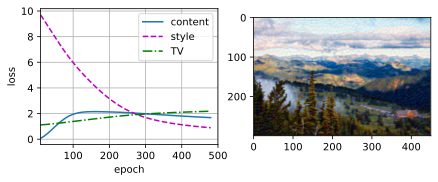

In [ ]:
def train(X, contents_Y, styles_Y, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram = get_inits(X, lr, styles_Y, lr_decay_epoch, num_epochs)
    network = Network(X, X.shape)
    lr_list = d2l.tensor([lr*(0.8**(i//lr_decay_epoch)) 
                      for i in range(num_epochs)])
    trainer = nn.Adam(network.get_parameters(), lr=lr_list)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    
    for epoch in range(num_epochs):
        # 定义前向网络
        def forward_fn():
            X, contents_Y_hat, styles_Y_hat = network()
            contents_l, styles_l, tv_l, l = compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
            return l
        #print(forward_fn())
        X, contents_Y_hat, styles_Y_hat = network()
        grad_fn = mindspore.value_and_grad(forward_fn, grad_position=None, weights=network.trainable_params())
        l, grads = grad_fn()
        trainer(grads)
        #print(network()[0])
    

        X, contents_Y_hat, styles_Y_hat = network()
        contents_l, styles_l, tv_l, l = compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        #print(contents_l, styles_l, tv_l, l)

        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
    
  
    return X
image_shape = (300, 450)
content_X, contents_Y = get_contents(image_shape)
_, styles_Y = get_styles(image_shape)
output = train(content_X, contents_Y, styles_Y, 0.3, 500, 50)